In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
import scipy.stats as stats
from scipy.stats import mannwhitneyu
import hashlib
import pandahouse as ph

In [3]:
#  Получим доступ к данным
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20250320'
}

In [5]:
# Проведем хэширование для проведения эксперимента 
q = """
SELECT xxHash64(toString(user_id)||'my_salt')%5 as group, 
    uniqExact(user_id)
FROM {db}.feed_actions 
WHERE toDate(time) >= '2025-02-21' and toDate(time) <= '2025-02-27' 
group by group 
"""

ph.read_clickhouse(q, connection=connection)

,group,uniqExact(user_id)
0,0,10027
1,1,9866
2,2,9916
3,3,10084
4,4,9921


In [7]:
# Извлечем нужные данные для проведения дальнейших тестов
query = """
SELECT exp_group, 
       user_id,
       sum(action = 'like') as likes,
       sum(action = 'view') as views,
       sum(action = 'like') / sum(action = 'view') as ctr
FROM simulator_20250320.feed_actions
WHERE toDate(time) between '2025-02-21' and '2025-02-27'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(query, connection=connection)
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,39,141,0.276596
4,1,18392,7,32,0.218750


In [17]:
# Проверим количество пользователей в интересующих нас группах
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


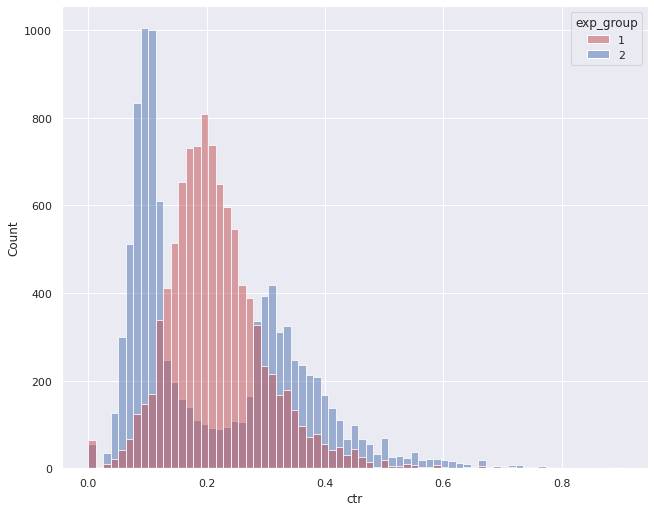

In [20]:
# Визуализируем CTR и просмотры
sns.set(rc={'figure.figsize':(10.5,8.5)})
groups = sns.histplot(data = df,
              x='ctr',
              hue='exp_group',
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

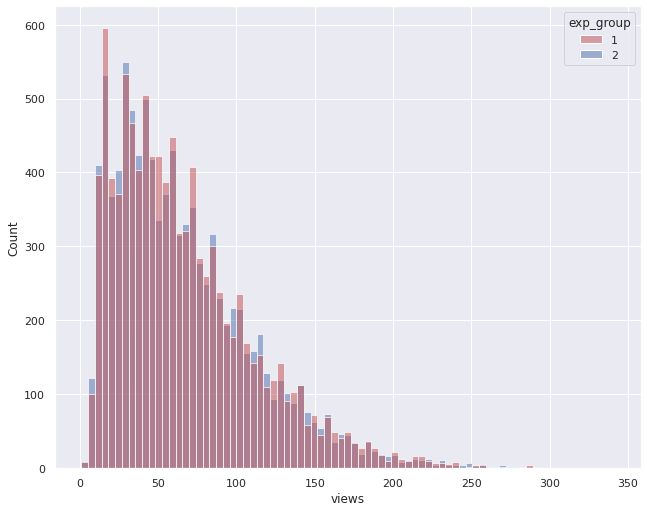

In [21]:
sns.set(rc={'figure.figsize':(10.5,8.5)})
groups = sns.histplot(data = df,
              x='views',
              hue='exp_group',
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [6]:
# Фильтруем группы
gr_1 = df[df.exp_group == 1]
gr_2 = df[df.exp_group == 2]

# Объединим данные по пользователям
combined = pd.concat([gr_1[['user_id', 'ctr']], gr_2[['user_id', 'ctr']]], keys=['group_1', 'group_2']).reset_index(level=0).rename(columns={'level_0': 'group'})

# Выполним t-тест
t_stat, p_value = stats.ttest_ind(combined[combined.group == 'group_1']['ctr'], 
                                   combined[combined.group == 'group_2']['ctr'], 
                                   equal_var=False)

print(f'T-statistic: {t_stat}, P-value: {p_value}')

if p_value < 0.05:
    print("Отвергаем нулевую гипотезу: есть статистически значимые различия между группами.")
else:
    print("Не можем отвергнуть нулевую гипотезу: нет статистически значимых различий между группами.")

T-statistic: 0.4051491913112423, P-value: 0.6853733311407757
Не можем отвергнуть нулевую гипотезу: нет статистически значимых различий между группами.


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


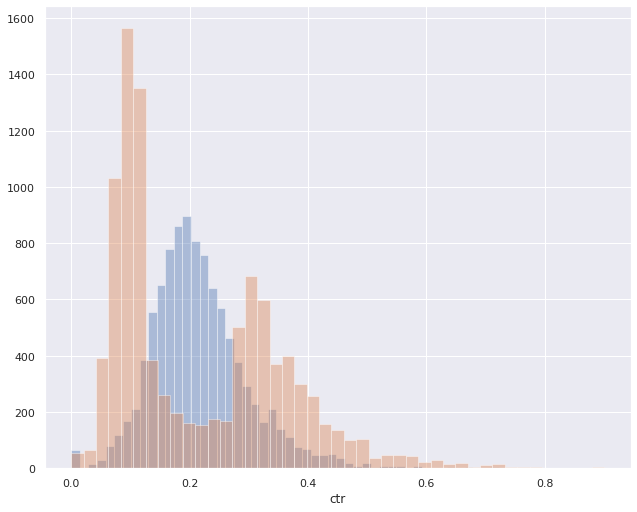

In [29]:
# Применим сглаживание CTR
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 2].views.sum()
global_ctr_2 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 2].views.sum()

group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

sns.distplot(group1.ctr, 
             kde = False)
sns.distplot(group2.ctr, 
             kde = False)

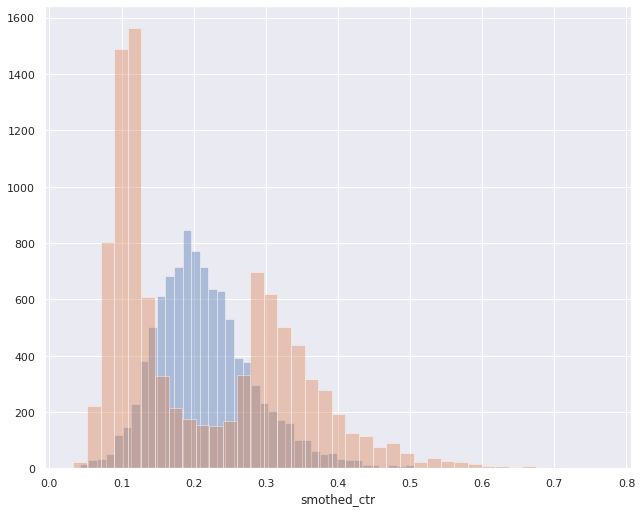

In [33]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.distplot(group1.smothed_ctr, 
             kde = False)
sns.distplot(group2.smothed_ctr, 
             kde = False)

In [34]:
t_stat, p_value = stats.ttest_ind(group1.smothed_ctr,
                  group2.smothed_ctr,
                  equal_var=True)
print(f'T-statistic: {t_stat}, P-value: {p_value}')

if p_value < 0.05:
    print("Отвергаем нулевую гипотезу: есть статистически значимые различия между группами.")
else:
    print("Не можем отвергнуть нулевую гипотезу: нет статистически значимых различий между группами.")

T-statistic: 1.247314556090133, P-value: 0.21229686459216743
Не можем отвергнуть нулевую гипотезу: нет статистически значимых различий между группами.


По результатам t-тестов статистически значимых отличий между группами нет.
График показывает, что в контрольной группе распределение нормальное, а в тестовой бимодальное, ввиду чего нецелосбразно использовать t-тест.

In [8]:
print('Дисперсия группы 1:', df[df.exp_group == 1].ctr.var())
print('Дисперсия группы 2:', df[df.exp_group == 2].ctr.var())

Дисперсия группы 1: 0.0068837939124764096
Дисперсия группы 2: 0.020411856094143838


Дисперсия тестовой группы значительно больше дисперсии контрольной группы, что так же говорит о том, что t-тест неприменим. Проведем тест Манна-Уитни

In [9]:
stat, p_value = mannwhitneyu(df[df.exp_group == 1].ctr, df[df.exp_group == 2].ctr)
print(f"Статистика U: {stat}, p-значение: {p_value}")

if p_value < 0.05:
    print("Отвергаем нулевую гипотезу: есть статистически значимые различия между группами.")
else:
    print("Не можем отвергнуть нулевую гипотезу: нет статистически значимых различий между группами.")

Статистика U: 55189913.0, p-значение: 4.632205841806026e-45
Отвергаем нулевую гипотезу: есть статистически значимые различия между группами.


Тест Манна-Уитни показал, что разница между группами есть, в отличие от t-теста.

До сих пор мы считали тесты на CTR по пользователям. Это хороший подход, но на самом деле нас интересует общий показатель по всей группе. С помощью бустрепа мы можем сравнить общегрупповой CTR в группах как
распределение. Будем использовать Пуассоновский бутстреп для подсчета разницы в CTR

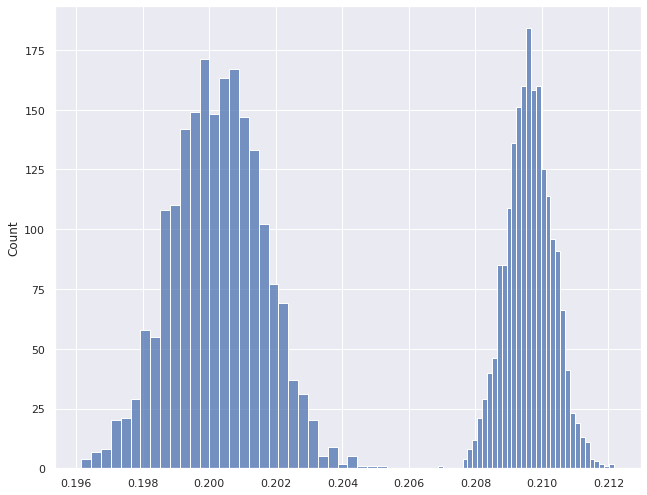

In [11]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes2))).astype(np.int64)
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1, globalCTR2

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)
sns.histplot(ctr1)
sns.histplot(ctr2)

Судя по графикам CTR отличаются в тестовой и контрольной группе

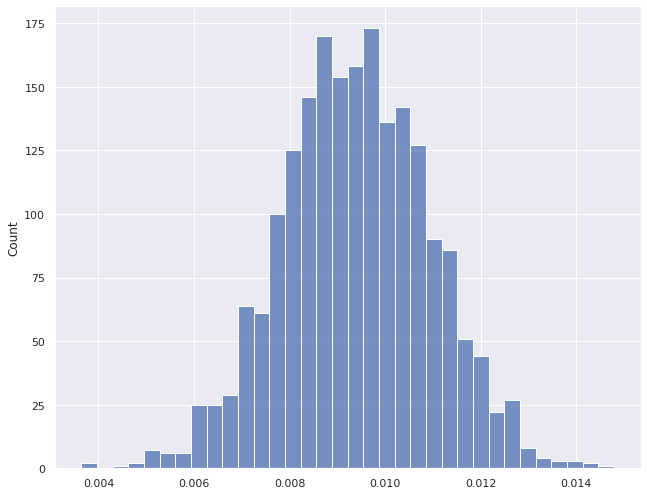

In [38]:
sns.histplot(ctr1 - ctr2)

Вывод: тест Манна-Уитни и Пуассоновский бутстреп показали наличие статистически значимой разницы между контрольной и тестовой группой, визуально на графиках разница тоже заметна
    
Однако в тестовой группе наблюдается бимодальное распределение, которое может быть вызвано как разной реакцией пользователей на новый алгоритм, так и отсутствием предобработки данных для проведения A/B теста путем исключения влияния иных факторов (возраст, город, пол и др.)
здесь и сейчас алгоритм лучше не внедрять поскольку для принятия решения о раскатке нового алгоритма следует провести новый A/B тест с бОльшим контролем над группами и учетом влияния иных факторов на потенциальное поведение аудитории. 
Одновременно с этим по результатам имеющегося теста можно сделать вывод о незначительном росте CTR.
    